In [1]:
import sys
sys.path.insert(1, './imports')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from exploratory_analysis import *
from preprocessing import *
from model_selection import *
from model_end_to_end import *
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt import gbrt_minimize
from skopt import forest_minimize

# Introduction

On the northwest sector of the Iberian peninsule, forest fires are a problem causing huge economic, ecological and humanitarian losses every year. Several studies suggest that these fires are mostly caused by humans, intentionally (up to 75% of the total number), or unintentionally (10%), and natural fires are rare, in contrast with other areas [1].  
The climate of the region is oceanic with mediterranean influence, which means mild weather over the year, with in general rainy weather, except for the rather dry summers. *Eucalyptus globulus* and *Pinus pinaster* (both pyrophytes, plants partially adapted to habitats where fires often happen, and invasive species) occupy huge areas of forests, and have a big economic importance, being the raw material of the cellulose pulp produced in that region, and used all over the EU for producing cardboard.  
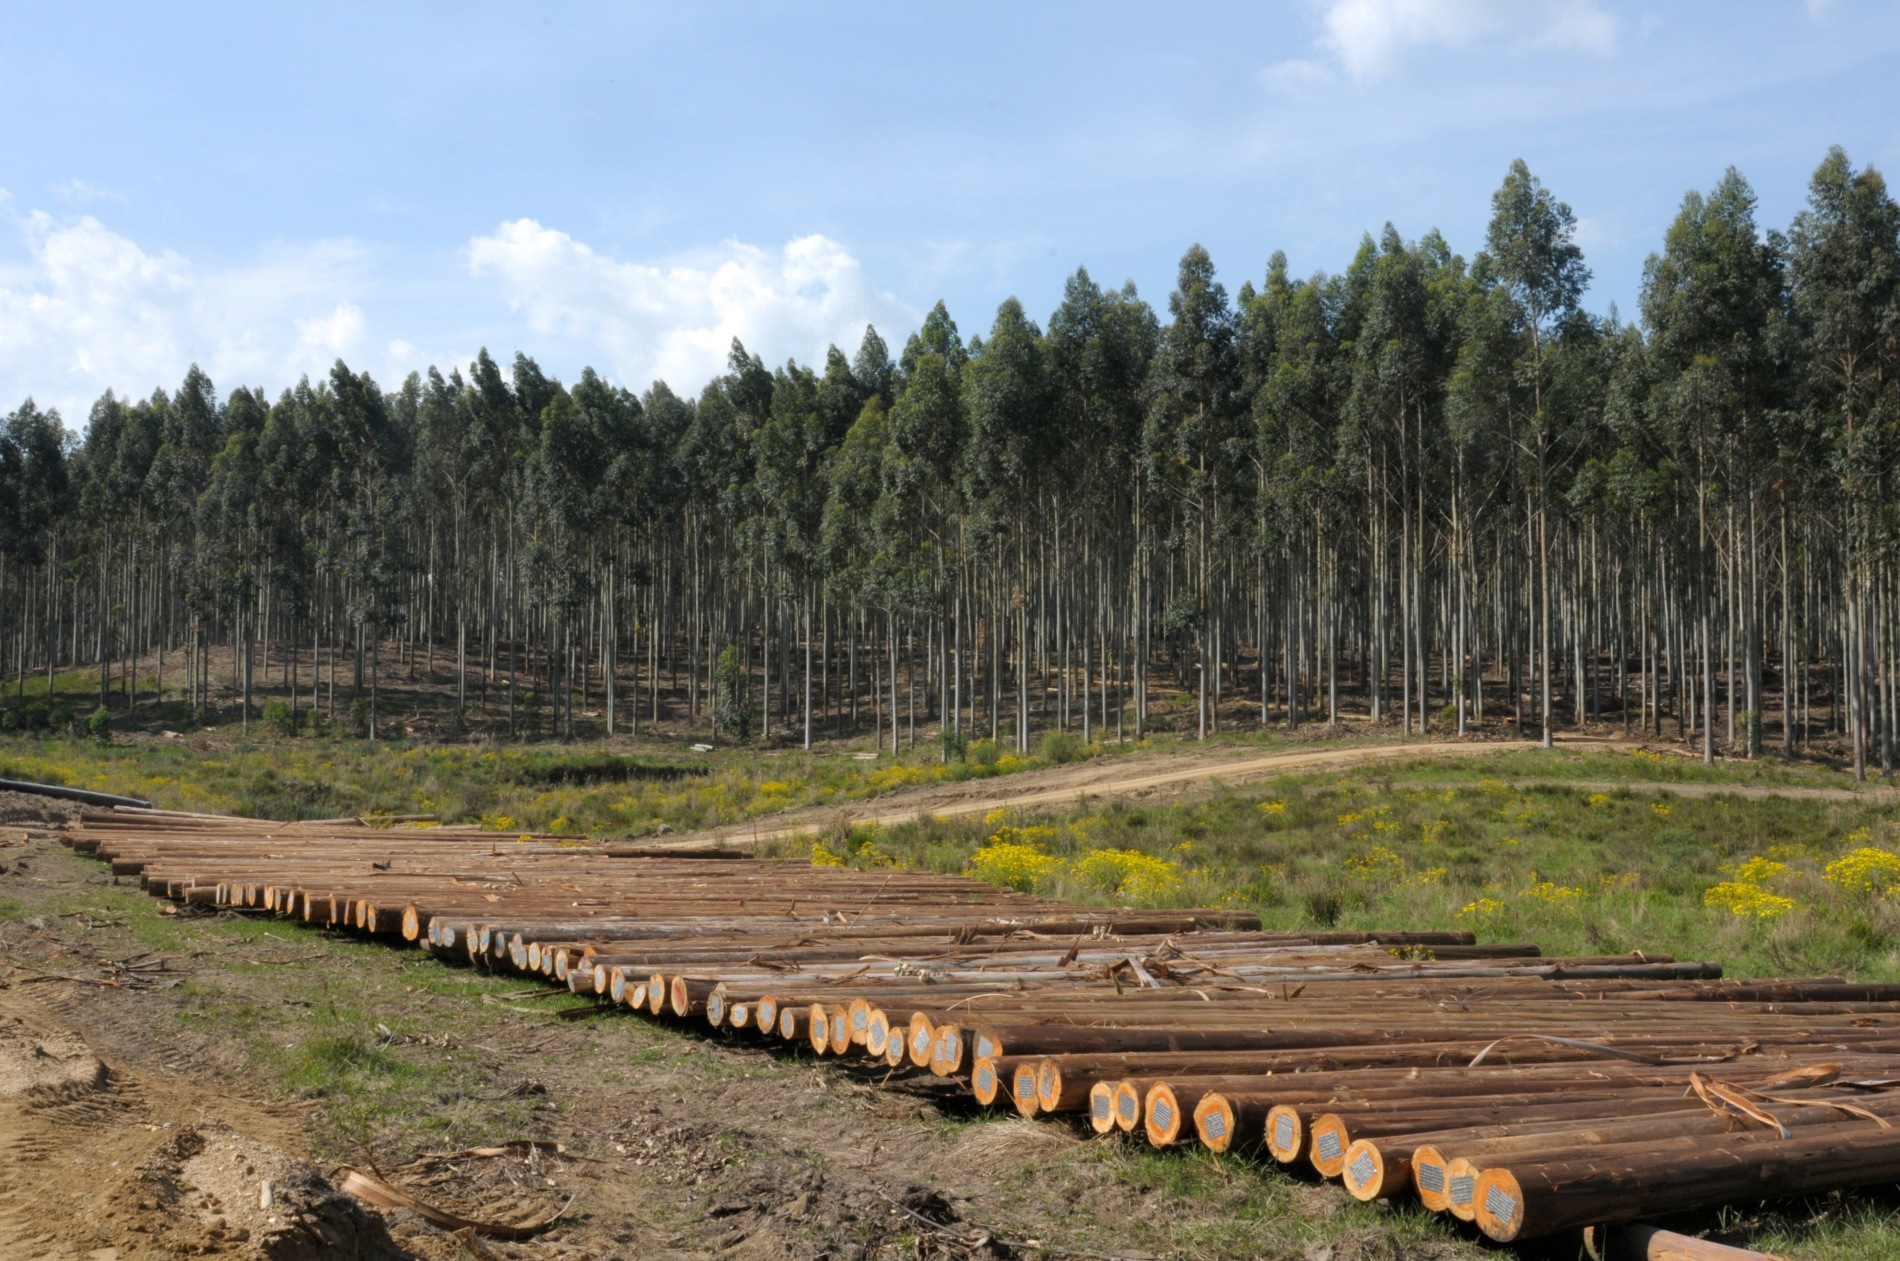
Furthermore, there are several natural and national parks in this area of huge ecologic importance, which recive thousands of visits every year.

[1]: Estudio estadístico de la causalidad de los incendios forestales en Galicia, by M.L. Chas Amil y J. Touza Montero

# Data preprocessing

In [2]:
fires = pd.read_csv("fires.csv")
fires.shape

(517, 13)

## Counting NAs

In [3]:
fires.isna().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

The dataset has no NA values

## Exploring discrete/categorical variables

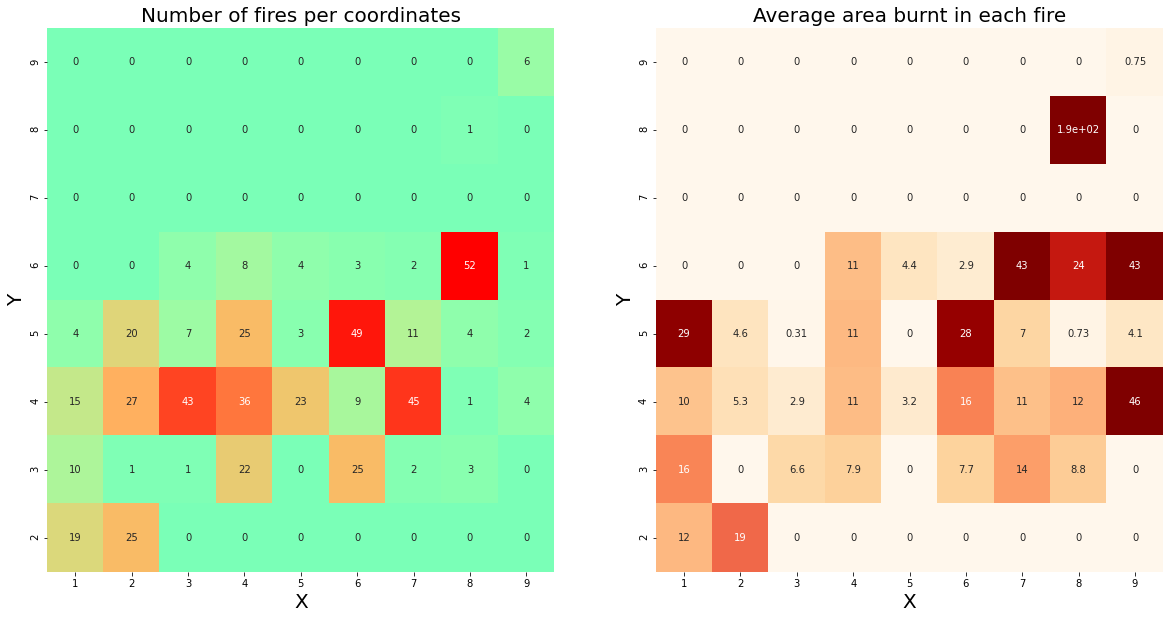

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
g1 = plot_xy_counts(fires, ax1)
g2 = plot_xy_averages(fires, ax2)
plt.show()

### Considering only the cases where area > 0

<AxesSubplot:title={'center':'Average area burnt when area > 0'}, xlabel='X', ylabel='Y'>

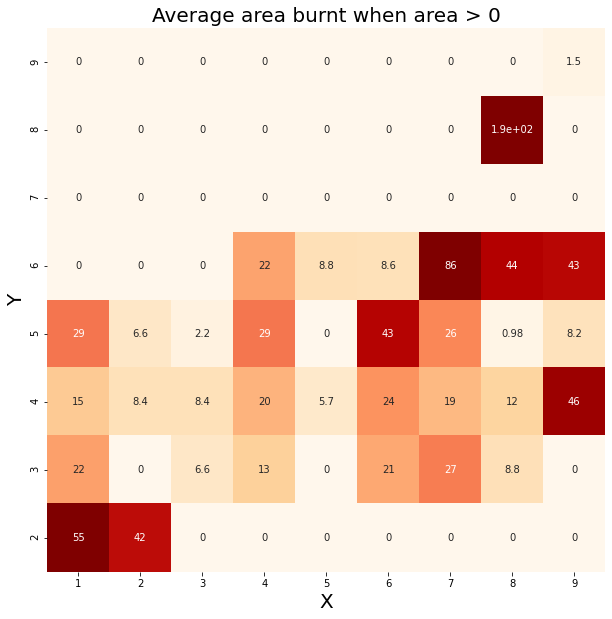

In [5]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()
nonzero_fires = fires[fires["area"]!=0]
plot_xy_averages(nonzero_fires, ax, title = "Average area burnt when area > 0", vmax=50)

We can observe:

- The distribution of fires is non-uniform, a lot of parcels have no fires
- As expected the spatial data is clearly non-normal
- Apparently there's to some degree an inverse correlation between the number of fires and the area burnt, which totally makes sense.
- There seems to be a hotspot of fires around [6, 8] botg ub frequency and intensity
- The detectability of the fires can be different for the different areas. 

Consequences:

- The data should be transformed
- Since a priori the data (tabular, not a big number of observations) could probably be a good target for tree classifers (Random forest, gradient boost...), feature engineering for capturing the spatial effects could be an advantage.

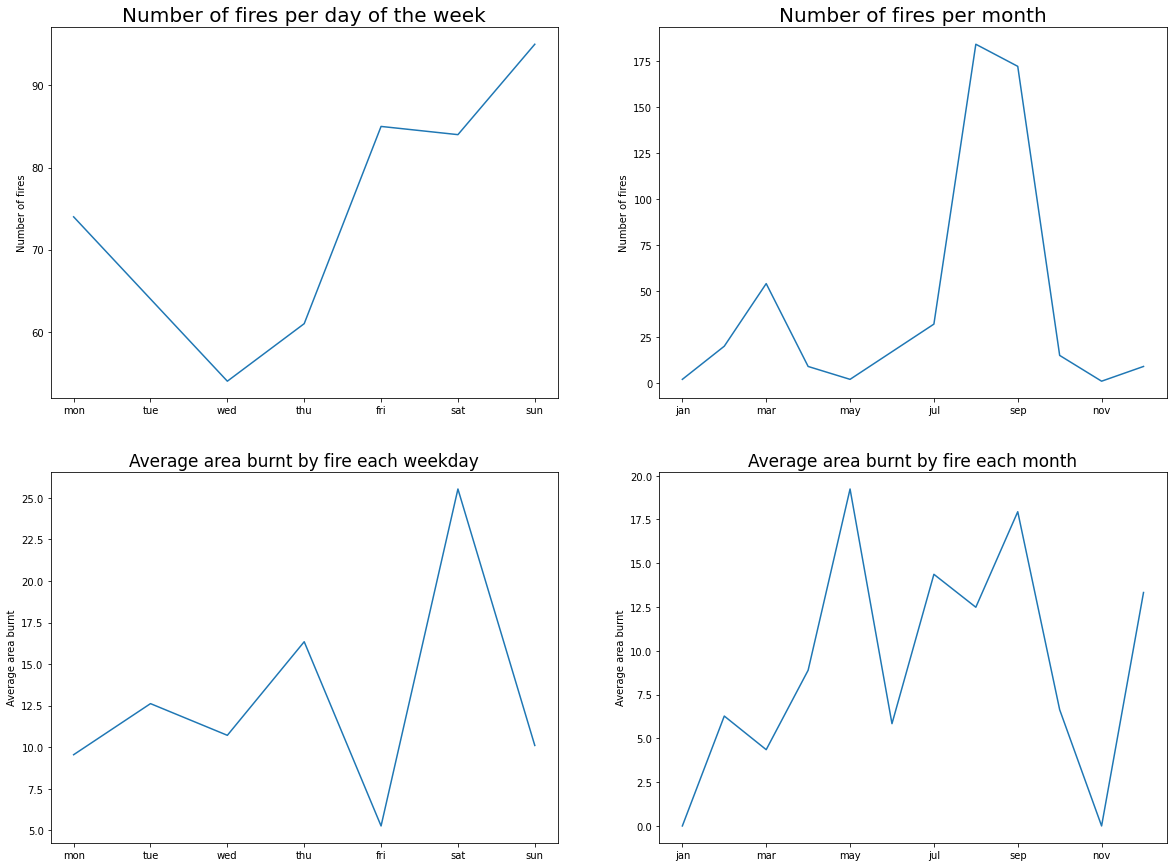

In [6]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
g1 = plot_weekday_counts(fires, ax1)
g2 = plot_month_counts(fires, ax2)
g3 = plot_weekday_averages(fires, ax3)
g4 = plot_month_averages(fires, ax4)
plt.show()

We can observe:

- The distribution of fires is non-uniform both along the months and the weekdays. The weekly pattern suggest that an important fraction of the fires could be unintetional burnings due to human activity or even arsons. The distribution along the year could be again related to human activity (between february and april and during the summer there are holidays), and of course the effect of the weather, with usually dry summers.
- There seems to be differences between the different months and days of the week about the average area burnt by fire, but there's no clear pattern.

Consequences:

- Data should be transformed
- One-hot encoding should be an appropiate transformation of the data


## Exploring continuous variables

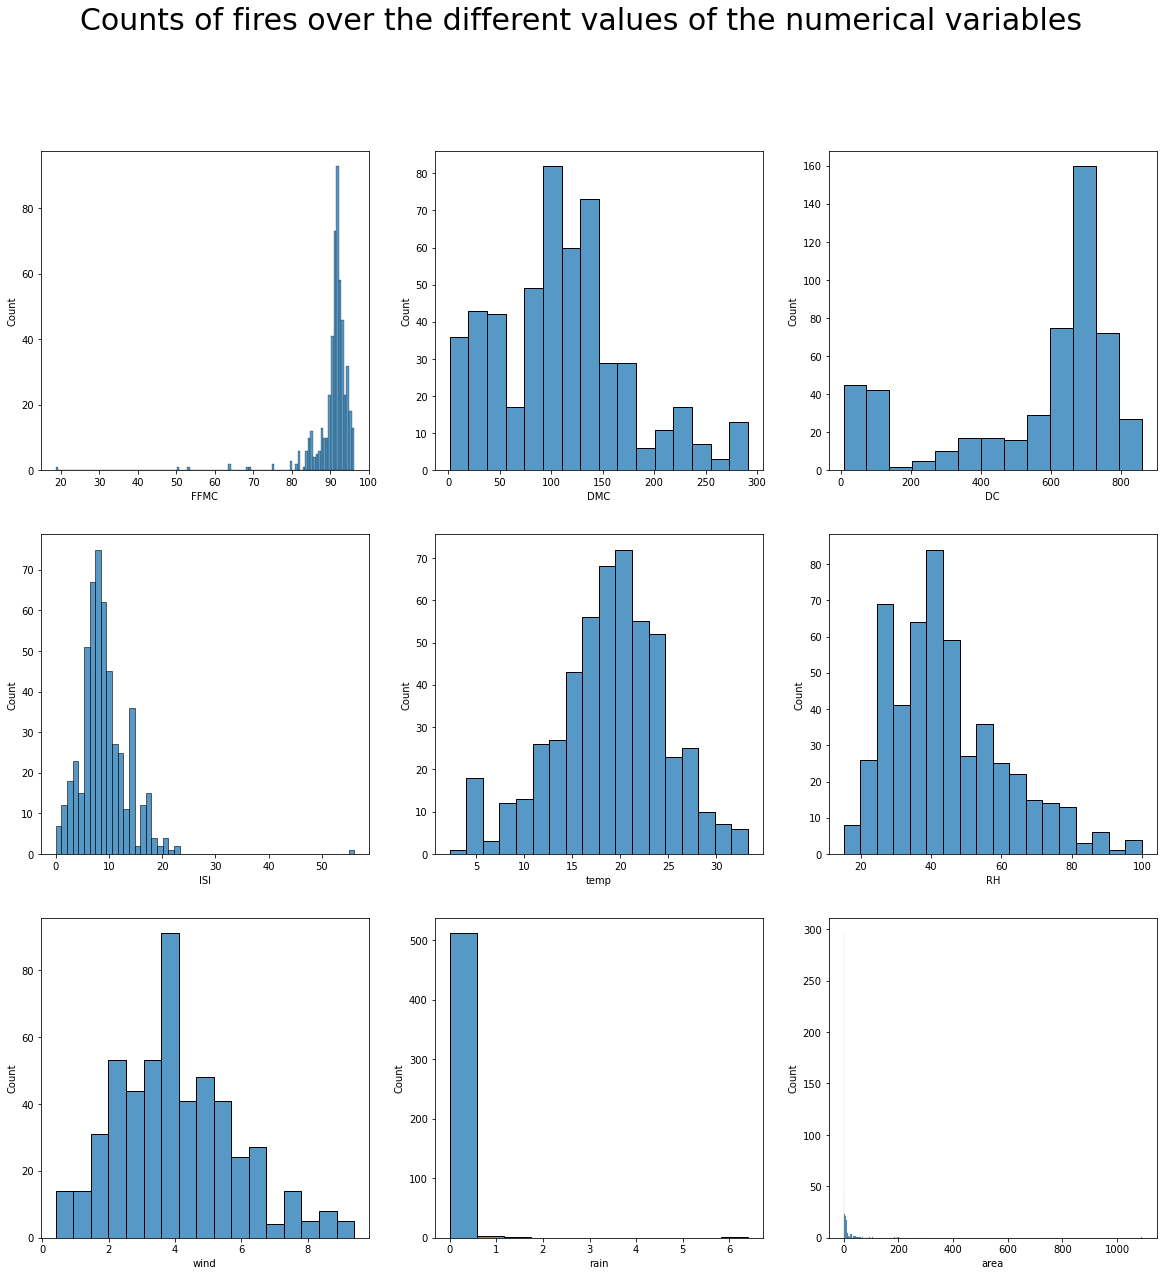

In [7]:
plot_numerical_counts(fires)

We can observe:

- Temp, and wind are probably close to being gaussian variables: Centering them should be enough and even could be unnecessary depending on the model.
- In FFMC, rain, ISI there are some outliers: They have to be dealt with.
- Rain and area have low resolution in this scale where a lot of values tend to be zero: one-hot enconding the zero and further exploration is necessary.
- DMC,ISI and RH seem close to normality but slightly skewed, probably some transormation would be benefitial.
- The distribution of FFMC and DC should be further explored to find a suitable transformation.

### Exploring "area"

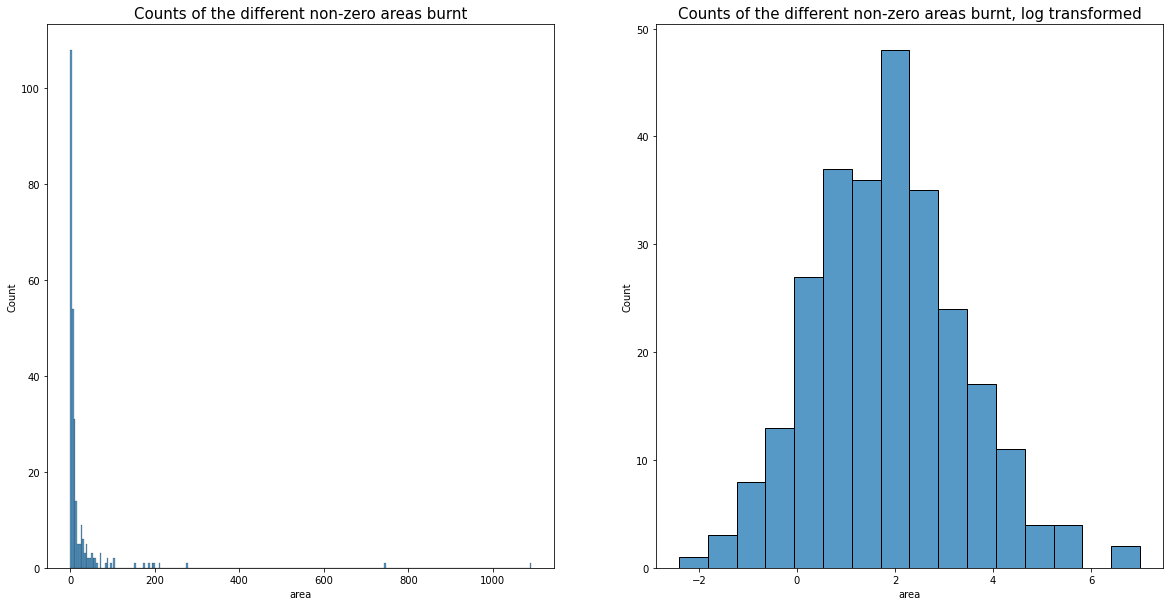

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plot_nonzero_area(fires, ax=axes[0])
plot_nonzero_area_logtransformed(fires, ax=axes[1])
plt.show()

After removing the 0 entries, and doing a log transformation, the target variable seems to follow a normal distribution

### Exploring "rain"

In [9]:
fires["rain"].value_counts()

0.0    509
0.8      2
0.2      2
0.4      1
1.4      1
6.4      1
1.0      1
Name: rain, dtype: int64

The rain variable seems to be mostly 0, which totally makes sense. After removal of the outlyer, the variable will be binary encoded.

### Exploring FFMC and ISI

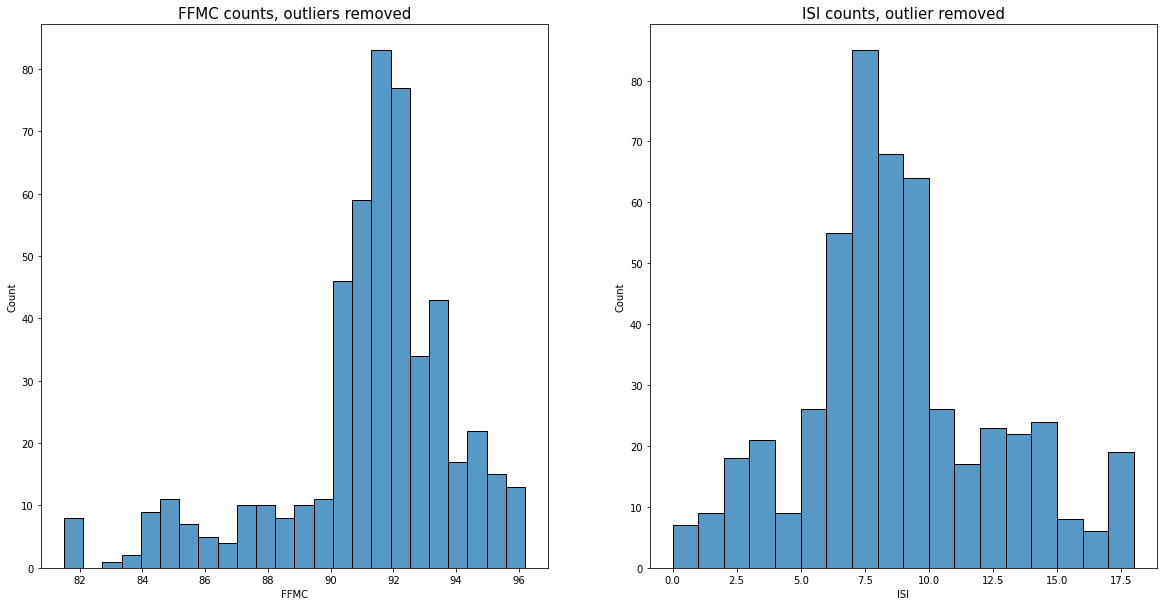

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plot_ffmc_wo_outliers(fires, ax=axes[0])
plot_ISI_wo_outliers(fires, ax=axes[1])
plt.show()

- The variable FFMC, even after removal of the outliers seems negative skewed. Since probably tree classifiers will be used, probably only the outliers will be removed or one-hot encoded and replaced by the mean
- The situation for ISI is similar.

### Exploring DC

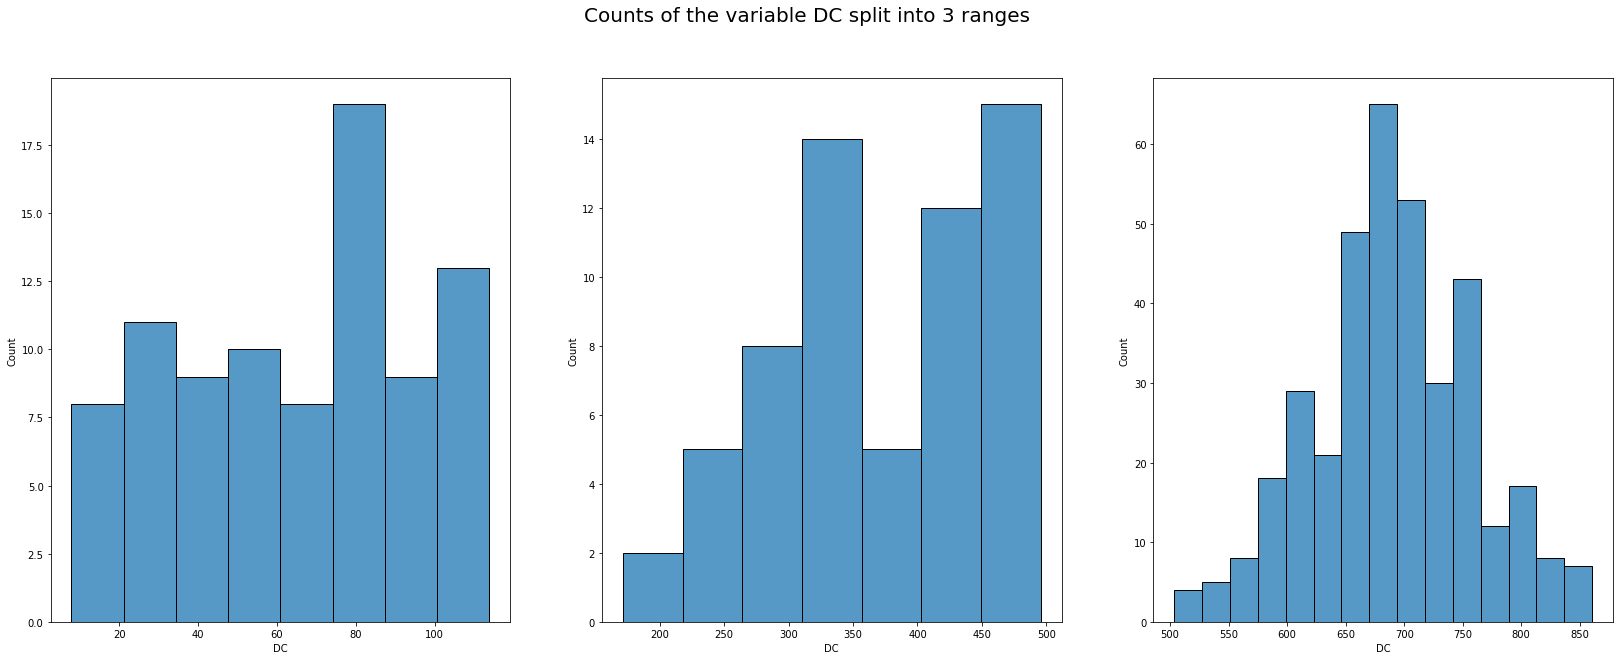

In [11]:
plot_DC_split(fires)

The variable can be apparently divided into two-three disjoint ranges, where most of the counts are in the range [500, 900] and present a distribution apparently close to normality

### Exploring RH

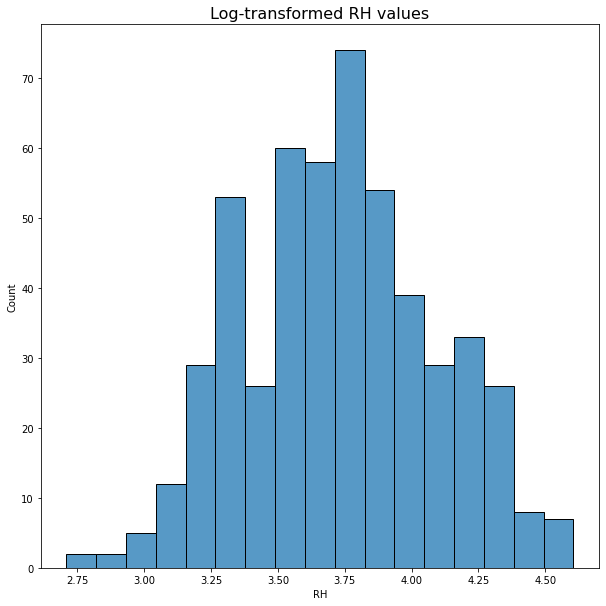

In [12]:
fig = plt.figure(figsize=(10, 10))
g = sns.histplot(np.log(fires["RH"]))
g.set_title("Log-transformed RH values", fontsize = 16)
plt.show()

After log transformation the values seem to follow a normal distribution

## After initial preprocessing

In [13]:
dpp = DataPreprocessor()
dpp.fit(fires)
processed_fires = dpp.transform_with_2target().iloc[:-1]
continuous_cols = ['DC', 'FFMC', 'DMC', 'ISI', 'temp', 'RH', 'wind', 'area']
continuous_cols_no_area = ['DC', 'FFMC', 'DMC', 'ISI', 'temp', 'RH', 'wind']

In [14]:
fires_cont = processed_fires[continuous_cols]

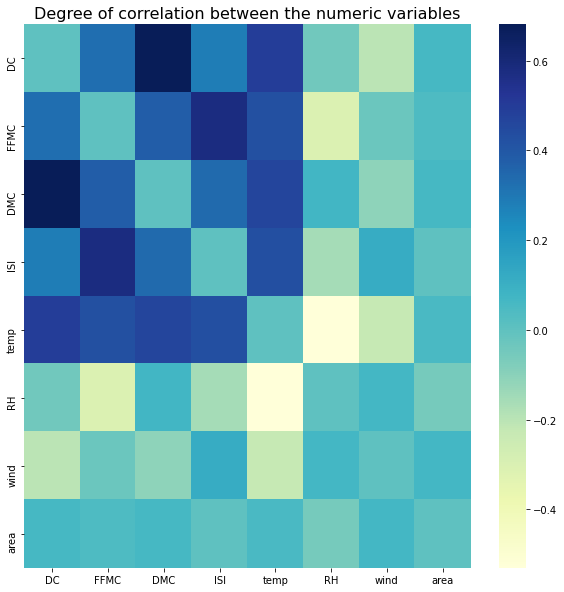

In [15]:
fig = plt.figure(figsize=(10, 10))
corr_test = fires_cont.corr().replace(1, 0)
g = sns.heatmap(corr_test, cmap="YlGnBu")
g.set_title("Degree of correlation between the numeric variables", fontsize=16)
plt.show()

In [16]:
corr_test.iloc[7,:]

DC      0.061827
FFMC    0.044954
DMC     0.064458
ISI     0.003303
temp    0.052308
RH     -0.055051
wind    0.067899
area    0.000000
Name: area, dtype: float64

The linear correlation between the numeric variables shows two things:

- There's a high correlation between several of the numeric variables: Hence dimensionality reduction could help improve the model
- The linear correlation between the target variable and the other variables is low: A linear regression model wouldn't be a proper model

In [17]:
#processed_fires.to_csv("fire_data_processed.csv")

save the processed data and the processor

In [18]:
dpp = DataPreprocessorPCA()
dpp.fit(fires)
processed_fires_pca = dpp.transform_with_2target()

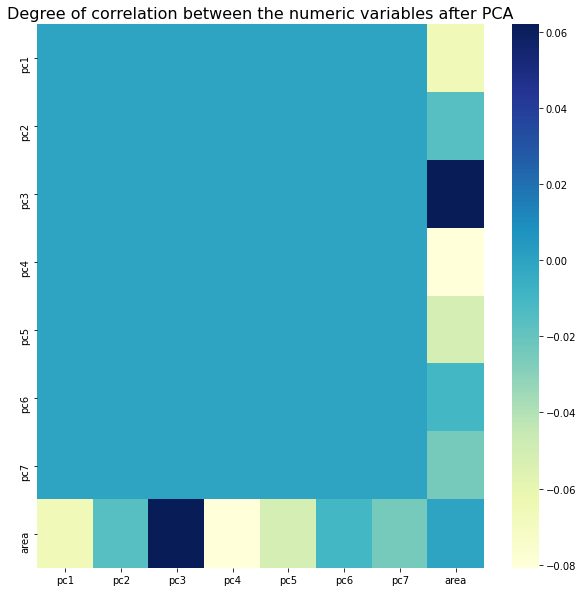

In [19]:
fig = plt.figure(figsize=(10, 10))
cont_cols = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'area']
g = sns.heatmap(processed_fires_pca.loc[:,cont_cols].corr().replace(1, 0), cmap="YlGnBu")
g.set_title("Degree of correlation between the numeric variables after PCA", fontsize=16)
plt.show()

In [20]:
#processed_fires_pca.to_csv("fire_data_processed_after_pca.csv")

After PCA, ignoring the self correlation of 1 for the diagonals, as expected the numeric variables are not correlated between themselves. Let's save this data

# Model Selection and evaluation

Preclassifying the data was futile. The methods tried were:

- Direct preclassification of the whole dtaset.
- Preclassification of the split dataset
- Preclassification using a SVM with a custom hinge loss, where the loss is dependent on the squared distance between a split hyperplane and the missclassified instance.

In my opinion, due to the distribution of the target variable (there's almost a 50/50 balance between 0 and non-zero instances), being able to preclassify the 0-burnt area instances would be crucial.

Probably we'd need more data and/or additional variables to do so, like:

- LiDar cloud points to have more data about the terrain.
- Type of vegetation in the surroundings
- Was the fire intentional?
- More detailed climatologic data over the recent days/weeks

Furthermore, the data could be not IID:
- The terrain and vegetation is transformed in a non-uniform manner, this adds noise at the X, Y level
- If one parcel was burnt to the ground a few months ago, then there's an additional variable not taken into account. Adding the year of the fire could help building a more complex model taking this into account.

I'll compare three different strategies I tried for solving directly the regression problem:

- The first method tried to use preclassification. Its performance it's difficult to evaluate, due to the multiple splits of the data. The mean absolute error is used as performance metric, but it's probably biased (optimistic) even if the performance of the model is not good.
- The second was a more or less greedy approach tuning the different hyperparameters using k-fold cross validation. Due to the repeated exposition of the model to the whole data, it's probably overfitting and is hence a biased estimate of the empirical risk.
- The third approach uses nested k-fold cross validation to search the model space using skopt. Has probably the lowest bias.


In [21]:
fires = pd.read_csv("fires.csv")

## Estimation of the average absolute loss in hA

## Model with preclassification and split of the data

In [22]:
msinho_acc = MontesinhoCompleteModel_evaluator(SVC(kernel = 'rbf', gamma=0.002652859881404326, C= 100, degree=5),
                                           SVC(C=8.41850316809234, gamma=0.04349773501643578, kernel='linear'),
                                           SVC(C=0.26869573356106563, degree=2, gamma=0.9600363819999834, kernel='poly'),
                                           PolynomialFeatures(degree=3),
                                           PolynomialFeatures(degree=1),
                                           PolynomialFeatures(degree=3),
                                           GradientBoostingRegressor(learning_rate= 0.1875, n_estimators= 20),
                                           GradientBoostingRegressor(learning_rate= 0.46, n_estimators= 20),
                                           GradientBoostingRegressor(learning_rate= 0.6, n_estimators= 20))
msinho_acc.fit(fires)
print("average absolute loss per instance, in hA: ", np.exp(msinho_acc.average_loss()) - 1)

average absolute loss per instance, in hA:  2.645174510009881


## Random Forest Regressor with hyperparameter tuning

In [23]:
montesinho_rfr = MontesinhoCompleteModel_evaluator_simple(RandomForestRegressor(criterion = "mse", n_estimators= 100), 1)
montesinho_rfr.fit(fires)
print("average absolute loss per instance, in hA: ", np.exp(montesinho_rfr.evaluate()) - 1)
montesinho_rfr.train()

average absolute loss per instance, in hA:  2.2116111853169267


## Gradient Boosting Regressor with hyperparameter tuning

In [24]:
montesinho_gbr = MontesinhoCompleteModel_evaluator_simple(GradientBoostingRegressor(learning_rate= 0.05, n_estimators= 100), 1)
montesinho_gbr.fit(fires)
print("average absolute loss per instance, in hA: ", np.exp(montesinho_gbr.evaluate()) - 1)
montesinho_gbr.train()

average absolute loss per instance, in hA:  2.222478482940867


## Gradient Boosting Regressor with feature engineering

In [25]:
features_removed = ['apr_bool', '66', '73', '65', '74', '64', '75', '95', '63', '99', '84', '55', '13', 'aug_bool', '76', '43', '44', '85', 'rain', '94', 'oct_bool', '45', '33', 'nov_bool', 'feb_bool', '23',
 'wed', 'mar_bool', 'fri', 'jun_bool', '14', 'tue', '24', '88', '46', 'sat']
features_added = [["22","sat"], ["wed","pc5"], ["tue","pc2"], ["94", "pc6"], ['sep_bool','pc4']]
montesinho_gbr_fe = MontesinhoCompleteModel_evaluator_fe(GradientBoostingRegressor(learning_rate= 0.05, n_estimators= 100), 1, features_added, features_removed)
montesinho_gbr_fe.fit(fires)
print("average absolute loss per instance, in hA: ", np.exp(montesinho_gbr_fe.evaluate()) - 1)
montesinho_gbr_fe.train()
#montesinho_gbr_fe.save_model("model_gbr_re.pickle")

average absolute loss per instance, in hA:  2.0376131250507155


## Gradient Boosting Regressor with bayesian optimization

In [ ]:
space  = [Integer(1, 20, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, processed_fires_pca.drop(["area_bool", "area"], axis=1).shape[1], name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]
gbr_sk = MontesinhoCompleteModel_evaluator_sk(GradientBoostingRegressor(), degree=1, feature_added = features_added, feature_removed = [], space=space)
gbr_sk.fit(fires)
print("average absolute loss per instance, in hA: ", np.exp(gbr_sk.score) - 1)

## Support Vector Regression with bayesian optimization of the hyperparameter space

In [ ]:
space  = [Categorical(['linear', 'poly', 'rbf', 'sigmoid'], name='kernel'),
          Integer(1, 3, name='degree'),
          Real(10**-5, 10**2, "log-uniform", name='gamma'),
          Real(10**-5, 10**2, "log-uniform", name='C')         ]
ridge_sk = MontesinhoCompleteModel_evaluator_sk(SVR(), degree=1, feature_added = features_added, feature_removed = [], space=space)
ridge_sk.fit(fires)
print("average absolute loss per instance, in hA: ", np.exp(ridge_sk.score) - 1)

## Random Forest Regressor with bayesian optimization

In [ ]:
space  = [Integer(1, 20, name='max_depth'),
          Integer(1, processed_fires_pca.drop(["area_bool", "area"], axis=1).shape[1], name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]
rfr_sk = MontesinhoCompleteModel_evaluator_sk(RandomForestRegressor(), degree=1, feature_added = features_added, feature_removed = [], space=space)
rfr_sk.fit(fires)
print("average absolute loss per instance, in hA: ", np.exp(rfr_sk.score) - 1)

# Model piecewise behaviour for the six simple models
Now, even if it's going to have a high variance, let's try to observe how the model works depending on the value of the target variable

In [ ]:
indexes_0 = fires[fires["area"] == 0].sample(25, random_state=3558).index
indexes_0_10 = fires[(fires["area"] != 0) & (fires["area"] <= 10)].sample(20, random_state=3558).index
indexes_10_40 = fires[(fires["area"] <= 40) & (fires["area"] > 10)].sample(20, random_state=3558).index
indexes_40_plus = fires[(fires["area"] > 40)].sample(10, random_state=3558).index
evaluation_indexes = [*indexes_0, *indexes_0_10, *indexes_10_40, *indexes_40_plus]
train_indexes = np.array([i for i in np.arange(0, fires.shape[0]-1) if i not in evaluation_indexes])
data_train = fires.iloc[train_indexes]
data_evaluation = fires.iloc[evaluation_indexes]

## Random Forest Regressor with hyperparameter tuning

In [ ]:
montesinho_rfr.fit(data_train)
montesinho_rfr.train()
df_0_rfr, df_0_10_rfr, df_10_40_rfr, df_40_plus_rfr = create_dfs(montesinho_rfr, fires, indexes_0, indexes_0_10, indexes_10_40, indexes_40_plus)

## Gradient Boosting Regressor with hyperparameter tuning

In [ ]:
montesinho_gbr.fit(data_train)
montesinho_gbr.train()
df_0_gbr , df_0_10_gbr, df_10_40_gbr, df_40_plus_gbr = create_dfs(montesinho_gbr, fires, indexes_0, indexes_0_10, indexes_10_40, indexes_40_plus)

## Gradient Boosting Regressor with feature engineering

In [ ]:
montesinho_gbr_fe.fit(data_train)
montesinho_gbr_fe.train()
df_0_gbr_fe, df_0_10_gbr_fe, df_10_40_gbr_fe, df_40_plus_gbr_fe = create_dfs(montesinho_gbr_fe, fires, indexes_0, indexes_0_10, indexes_10_40, indexes_40_plus)

## Skopt Gradient Boosting Regressor

In [ ]:
gbr_sk = MontesinhoCompleteModel_evaluator_sk(GradientBoostingRegressor(), degree=1, feature_added = features_added, feature_removed = [], space=space)
gbr_sk.fit(data_train)
gbr_sk.train()
df_0_gbr_sk, df_0_10_gbr_sk, df_10_40_gbr_sk, df_40_plus_gbr_sk = create_dfs(gbr_sk, fires, indexes_0, indexes_0_10, indexes_10_40, indexes_40_plus)

## Skopt Random Forest

In [ ]:
rfr_sk.fit(data_train)
rfr_sk.train()
df_0_rfr_sk, df_0_10_rfr_sk, df_10_40_rfr_sk, df_40_plus_rfr_sk = create_dfs(rfr_sk, fires, indexes_0, indexes_0_10, indexes_10_40, indexes_40_plus)

## Skopt Ridge

In [ ]:
ridge_sk.fit(data_train)
ridge_sk.train()
df_0_ridge_sk, df_0_10_ridge_sk, df_10_40_ridge_sk, df_40_plus_ridge_sk = create_dfs(ridge_sk, fires, indexes_0, indexes_0_10, indexes_10_40, indexes_40_plus)

### Visual comparaison

In [ ]:
fig, [(ax1, ax2, ax3), (ax4, ax5, ax6)] = plt.subplots(2, 3, figsize=(18, 20))
fig.suptitle("Different preddictions of the models when the real area was 0", fontsize=20)
g1 = sns.boxplot(y = "pred", data=df_0_rfr, ax=ax1)
g1.set_ylim([0, 8])
g1.set_ylabel("Predicted area (hA)")
g1.set_title("Random Forest Regressor", fontsize=16)
g2 = sns.boxplot(y = "pred", data=df_0_gbr, ax=ax2)
g2.set_ylim([0, 8])
g2.set_ylabel("")
g3 = sns.boxplot(y = "pred", data=df_0_gbr_fe, ax=ax3)
g3.set_ylim([0, 8])
g2.set_title("Gradient Boosting Regressor", fontsize=16)
g3.set_ylabel("")
g3.set_title("GBR + Feature modifications", fontsize=16)
g4 = sns.boxplot(y = "pred", data=df_0_gbr_sk, ax=ax4)
g4.set_ylim([0, 8])
g4.set_ylabel("Predicted area (hA)")
g4.set_title("Gradient Boosting (Skopt)", fontsize=16)
g5 = sns.boxplot(y = "pred", data=df_0_rfr_sk, ax=ax5)
g5.set_ylim([0, 8])
g5.set_ylabel("")
g6 = sns.boxplot(y = "pred", data=df_0_ridge_sk, ax=ax6)
g6.set_ylim([0, 8])
g5.set_title("Random Forest (Skopt)", fontsize=16)
g5.set_ylabel("")
g6.set_title("Ridge Regression (Skopt)", fontsize=16)
plt.show()

In [ ]:
from scipy.stats import pearsonr
fig, [(ax1, ax2, ax3), (ax4, ax5, ax6)] = plt.subplots(2, 3, figsize=(34, 20))
fig.suptitle("Different preddictions of the models when the real area $\in$ (0, 10]", fontsize=20)
g1 = sns.regplot(y = "pred", x="obs", data=df_0_10_rfr, ax=ax1)
g1.set_ylim([1, 8])
ax1.text(1, 7, "Pearson R:{}".format(pearsonr(df_0_10_rfr["obs"], df_0_10_rfr["pred"])[0]), fontsize=12)
g1.set_ylabel("Predicted area (hA)")
g1.set_title("Random Forest Regressor", fontsize=16)
g2 = sns.regplot(y = "pred", x="obs", data=df_0_10_gbr, ax=ax2)
g2.set_ylim([1, 8])
ax2.text(1, 7, "Pearson R:{}".format(pearsonr(df_0_10_gbr["obs"], df_0_10_gbr["pred"])[0]), fontsize=12)
g2.set_ylabel("")
g3 = sns.regplot(y = "pred", x="obs", data=df_0_10_gbr_fe, ax=ax3)
g3.set_ylim([1, 8])
ax3.text(1, 7, "Pearson R:{}".format(pearsonr(df_0_10_gbr_fe["obs"], df_0_10_gbr_fe["pred"])[0]), fontsize=12)
g2.set_title("Gradient Boosting Regressor", fontsize=16)
g3.set_ylabel("")
g3.set_title("GBR + Feature modifications", fontsize=16)
g1.set_xlabel("Actual area burnt (hA)")
g2.set_xlabel("Actual area burnt (hA)")
g3.set_xlabel("Actual area burnt (hA)")
g4 = sns.regplot(y = "pred", x="obs", data=df_0_10_gbr_sk, ax=ax4)
g4.set_ylim([1, 8])
ax4.text(1, 7, "Pearson R:{}".format(pearsonr(df_0_10_gbr_sk["obs"], df_0_10_gbr_sk["pred"])[0]), fontsize=12)
g4.set_ylabel("Predicted area (hA)")
g5 = sns.regplot(y = "pred", x="obs", data=df_0_10_rfr_sk, ax=ax5)
g5.set_ylim([1, 8])
ax5.text(1, 7, "Pearson R:{}".format(pearsonr(df_0_10_rfr_sk["obs"], df_0_10_rfr_sk["pred"])[0]), fontsize=12)
g5.set_ylabel("")
g6 = sns.regplot(y = "pred", x="obs", data=df_0_10_ridge_sk, ax=ax6)
g6.set_ylim([1, 8])
ax6.text(1, 7, "Pearson R:{}".format(pearsonr(df_0_10_ridge_sk["obs"], df_0_10_ridge_sk["pred"])[0]), fontsize=12)
g6.set_ylabel("")
g4.set_xlabel("Actual area burnt (hA)")
g5.set_xlabel("Actual area burnt (hA)")
g6.set_xlabel("Actual area burnt (hA)")
g4.set_title("Gradient Boosting (Skopt)", fontsize=16)
g5.set_title("Random Forest (Skopt)", fontsize=16)
g6.set_title("Ridge Regression (Skopt)", fontsize=16)
plt.show()

In [ ]:
fig, [(ax1, ax2, ax3), (ax4, ax5, ax6)] = plt.subplots(2, 3, figsize=(34, 20))
fig.suptitle("Different preddictions of the models when the real area $\in$ (10, 40]", fontsize=20)
g1 = sns.regplot(y = "pred", x="obs", data=df_10_40_rfr, ax=ax1)
g1.set_ylim([0, 20])
ax1.text(15, 13, "Pearson R:{}".format(pearsonr(df_10_40_rfr["obs"], df_10_40_rfr["pred"])[0]), fontsize=12)
g1.set_ylabel("Predicted area (hA)")
g1.set_title("Random Forest Regressor", fontsize=16)
g2 = sns.regplot(y = "pred", x="obs", data=df_10_40_gbr, ax=ax2)
g2.set_ylim([0, 20])
ax2.text(15, 13, "Pearson R:{}".format(pearsonr(df_10_40_gbr["obs"], df_10_40_gbr["pred"])[0]), fontsize=12)
g2.set_ylabel("")
g3 = sns.regplot(y = "pred", x="obs", data=df_10_40_gbr_fe, ax=ax3)
g3.set_ylim([0, 20])
ax3.text(15, 13, "Pearson R:{}".format(pearsonr(df_10_40_gbr_fe["obs"], df_10_40_gbr_fe["pred"])[0]), fontsize=12)
g2.set_title("Gradient Boosting Regressor", fontsize=16)
g3.set_ylabel("")
g3.set_title("GBR + Feature modifications", fontsize=16)
g1.set_xlabel("Actual area burnt (hA)")
g2.set_xlabel("Actual area burnt (hA)")
g3.set_xlabel("Actual area burnt (hA)")

g4 = sns.regplot(y = "pred", x="obs", data=df_10_40_gbr_sk, ax=ax4)
g4.set_ylim([0, 20])
ax4.text(15, 13, "Pearson R:{}".format(pearsonr(df_10_40_gbr_sk["obs"], df_10_40_gbr_sk["pred"])[0]), fontsize=12)
g4.set_ylabel("Predicted area (hA)")
g5 = sns.regplot(y = "pred", x="obs", data=df_10_40_rfr_sk, ax=ax5)
g5.set_ylim([0, 20])
ax5.text(15, 13, "Pearson R:{}".format(pearsonr(df_10_40_rfr_sk["obs"], df_10_40_rfr_sk["pred"])[0]), fontsize=12)
g5.set_ylabel("")
g6 = sns.regplot(y = "pred", x="obs", data=df_10_40_ridge_sk, ax=ax6)
g6.set_ylim([0, 20])
ax6.text(15, 13, "Pearson R:{}".format(pearsonr(df_10_40_ridge_sk["obs"], df_10_40_ridge_sk["pred"])[0]), fontsize=12)
g6.set_ylabel("")
g4.set_xlabel("Actual area burnt (hA)")
g5.set_xlabel("Actual area burnt (hA)")
g6.set_xlabel("Actual area burnt (hA)")
g4.set_title("Gradient Boosting (Skopt)", fontsize=16)
g5.set_title("Random Forest (Skopt)", fontsize=16)
g6.set_title("Ridge Regression (Skopt)", fontsize=16)
plt.show()

In [ ]:
fig, [(ax1, ax2, ax3), (ax4, ax5, ax6)] = plt.subplots(2, 3, figsize=(34, 20))
fig.suptitle("Different preddictions of the models when the real area $\in$ (40, $\infty$)", fontsize=20)
g1 = sns.regplot(y = "pred", x="obs", data=df_40_plus_rfr, ax=ax1)
g1.set_ylim([0, 55])
ax1.text(60, 45, "Pearson R:{}".format(pearsonr(df_40_plus_rfr["obs"], df_40_plus_rfr["pred"])[0]), fontsize=12)
g1.set_ylabel("Predicted area (hA)")
g1.set_title("Random Forest Regressor", fontsize=16)
g2 = sns.regplot(y = "pred", x="obs", data=df_40_plus_gbr, ax=ax2)
g2.set_ylim([0, 55])
ax2.text(60, 45, "Pearson R:{}".format(pearsonr(df_40_plus_gbr["obs"], df_40_plus_gbr["pred"])[0]), fontsize=12)
g2.set_ylabel("")
g3 = sns.regplot(y = "pred", x="obs", data=df_40_plus_gbr_fe, ax=ax3)
g3.set_ylim([0, 55])
ax3.text(60, 45, "Pearson R:{}".format(pearsonr(df_40_plus_gbr_fe["obs"], df_40_plus_gbr_fe["pred"])[0]), fontsize=12)
g2.set_title("Gradient Boosting Regressor", fontsize=16)
g3.set_ylabel("")
g3.set_title("GBR + Feature modifications", fontsize=16)
g1.set_xlabel("Actual area burnt (hA)")
g2.set_xlabel("Actual area burnt (hA)")
g3.set_xlabel("Actual area burnt (hA)")

g4 = sns.regplot(y = "pred", x="obs", data=df_40_plus_gbr_sk, ax=ax4)
g4.set_ylim([0, 55])
ax4.text(60, 45, "Pearson R:{}".format(pearsonr(df_gbr_sk["obs"], df_gbr_sk["pred"])[0]), fontsize=12)
g4.set_ylabel("Predicted area (hA)")
g5 = sns.regplot(y = "pred", x="obs", data=df_40_plus_rfr_sk, ax=ax5)
g5.set_ylim([0, 55])
ax5.text(60, 45, "Pearson R:{}".format(pearsonr(df_rfr_sk["obs"], df_rfr_sk["pred"])[0]), fontsize=12)
g5.set_ylabel("")
g6 = sns.regplot(y = "pred", x="obs", data=df_ridge_sk, ax=ax6)
g6.set_ylim([0, 55])
ax6.text(60, 45, "Pearson R:{}".format(pearsonr(df_ridge_sk["obs"], df_ridge_sk["pred"])[0]), fontsize=12)
g6.set_ylabel("")
g4.set_xlabel("Actual area burnt (hA)")
g5.set_xlabel("Actual area burnt (hA)")
g6.set_xlabel("Actual area burnt (hA)")
g4.set_title("Gradient Boosting (Skopt)", fontsize=16)
g5.set_title("Random Forest (Skopt)", fontsize=16)
g6.set_title("Ridge Regression (Skopt)", fontsize=16)
plt.show()

In [ ]:
df_gbr = pd.concat([df_0_10_gbr, df_10_40_gbr, df_40_plus_gbr], axis=0)
df_gbr_fe = pd.concat([df_0_10_gbr_fe, df_10_40_gbr_fe, df_40_plus_gbr_fe], axis=0)
df_rfr = pd.concat([df_0_10_rfr, df_10_40_rfr, df_40_plus_rfr], axis=0)
df_rfr_sk = pd.concat([df_0_10_rfr_sk, df_10_40_rfr_sk, df_40_plus_rfr_sk], axis=0)
df_ridge_sk = pd.concat([df_0_10_ridge_sk, df_10_40_ridge_sk, df_40_plus_ridge_sk], axis=0)
df_gbr_sk = pd.concat([df_0_10_gbr_sk, df_10_40_gbr_sk, df_40_plus_gbr_sk], axis=0)
fig, [(ax1, ax2, ax3), (ax4, ax5, ax6)] = plt.subplots(2, 3, figsize=(34, 20))
fig.suptitle("Different preddictions of the models when the real area $\in$ (0, $\infty$)", fontsize=20)
g1 = sns.regplot(y = "pred", x="obs", data=df_rfr, ax=ax1)
g1.set_ylim([0, 55])
ax1.text(60, 45, "Pearson R:{}".format(pearsonr(df_rfr["obs"], df_rfr["pred"])[0]), fontsize=12)
g1.set_ylabel("Predicted area (hA)")
g1.set_title("Random Forest Regressor", fontsize=16)
g2 = sns.regplot(y = "pred", x="obs", data=df_gbr, ax=ax2)
g2.set_ylim([0, 55])
ax2.text(60, 45, "Pearson R:{}".format(pearsonr(df_gbr["obs"], df_gbr["pred"])[0]), fontsize=12)
g2.set_ylabel("")
g3 = sns.regplot(y = "pred", x="obs", data=df_gbr_fe, ax=ax3)
g3.set_ylim([0, 55])
ax3.text(60, 45, "Pearson R:{}".format(pearsonr(df_gbr_fe["obs"], df_gbr_fe["pred"])[0]), fontsize=12)
g2.set_title("Gradient Boosting Regressor", fontsize=16)
g3.set_ylabel("")
g3.set_title("GBR + Feature modifications", fontsize=16)
g1.set_xlabel("Actual area burnt (hA)")
g2.set_xlabel("Actual area burnt (hA)")
g3.set_xlabel("Actual area burnt (hA)")

g4 = sns.regplot(y = "pred", x="obs", data=pd.concat([df_0_10_gbr_sk, df_10_40_gbr_sk, df_40_plus_gbr_sk]), ax=ax4)
g4.set_ylim([0, 55])
ax4.text(60, 45, "Pearson R:{}".format(pearsonr(df_40_plus_gbr_sk["obs"], df_40_plus_gbr_sk["pred"])[0]), fontsize=12)
g4.set_ylabel("Predicted area (hA)")
g5 = sns.regplot(y = "pred", x="obs", data=pd.concat([df_0_10_rfr_sk, df_10_40_rfr_sk, df_40_plus_rfr_sk]), ax=ax5)
g5.set_ylim([0, 55])
ax5.text(60, 45, "Pearson R:{}".format(pearsonr(df_40_plus_rfr_sk["obs"], df_40_plus_rfr_sk["pred"])[0]), fontsize=12)
g5.set_ylabel("")
g6 = sns.regplot(y = "pred", x="obs", data=pd.concat([df_0_10_ridge_sk, df_10_40_ridge_sk, df_40_plus_ridge_sk]), ax=ax6)
g6.set_ylim([0, 55])
ax6.text(60, 45, "Pearson R:{}".format(pearsonr(df_40_plus_ridge_sk["obs"], df_40_plus_ridge_sk["pred"])[0]), fontsize=12)
g6.set_ylabel("")
g4.set_xlabel("Actual area burnt (hA)")
g5.set_xlabel("Actual area burnt (hA)")
g6.set_xlabel("Actual area burnt (hA)")
g4.set_title("Gradient Boosting (Skopt)", fontsize=16)
g5.set_title("Random Forest (Skopt)", fontsize=16)
g6.set_title("Ridge Regression (Skopt)", fontsize=16)
plt.show()

In conclussion:

- Even when the difference in average loss was not huge, a huge difference in the models can be observed. This is probably because fires with lower areas burnt are a major fraction of the observations.
- With respect to the mean in the intervals, the models work better where the burnt area is small
- All models are overestimating the fires where the area burnt was 0. This is to expected, due to the use of log-scaling for training the algorithms
- Models 2 and 3 perform (apparently) significantly better in the instances where the area was 0
- For $y \in (0, 10]$ the fine-tuned model performs (apparently) better than the other two models. The RF regressor behaves here very close to random, and the GB regressor without feature engineering is between both.
- There seems to be some instances where the third model yields accurate predictions and others where it behaves randomly. This supports the idea of one or more latent variables that are not captured in the data.
- For $y \in (10, 40]$ both three models have a similar behaviour: Few instances are correctly predicted, the other have even a negative correlation
- $y \in (40, \infty]$ the models 2 and 3 behave similarly, again there are some instances where the predictions are closer to the real value, and others where they are close to the average on the interval. Model 1 doesn't have apparently any predictive power on this interval
- On the interval $y \in (0, \infty]$, models 2 and 3 behave similarly, model 2 apparently has a higher correlation coefficient between the real and predicted values. The random forest regressor seems almost like a blob with no correlation.
- Model 3 and 2 perform better than 1. Model 3 performs better predicting small fires, which correspond to the majority of the training instances. That's the probably the reason why it has a slighly lower average absolute loss.